# MNIST-Project-Using-ANN
## Introduction

The MNIST (Modified National Institute of Standards and Technology) dataset from [kaggle](https://www.kaggle.com/datasets/oddrationale/mnist-in-csv/data) is one of the most widely used benchmarks in machine learning for image classification tasks. It consists of 70,000 grayscale images of handwritten digits (0-9), with 60,000 images in the training set and 10,000 images in the test set. Each image is 28x28 pixels in size, making it a relatively simple dataset for digit recognition tasks. The dataset serves as a foundational problem for training neural networks, enabling models to learn how to recognize and classify handwritten digits.

## Problem Statement

The goal of this project is to build a simple Artificial Neural Network (ANN) model that can accurately classify handwritten digits from the MNIST dataset. Given the complexity of the human task of recognizing digits with varying handwriting styles, an ANN will be trained to automate this classification process. By using a basic neural network architecture, the project will demonstrate how even simple models can achieve high accuracy on image classification tasks with relatively low computational complexity.
Here’s a fun, simple guide for what to include in your README file for the MNIST handwritten digit classification project:

## Data Collection

In [1]:
# Import the neccessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchmetrics import Accuracy

In [2]:
#Read Data
df = pd.read_csv("mnist_train.csv")

df.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Exploratory Data Analysis(EDA)

In [3]:
# Explore Data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to 28x28
dtypes: int64(785)
memory usage: 359.3 MB


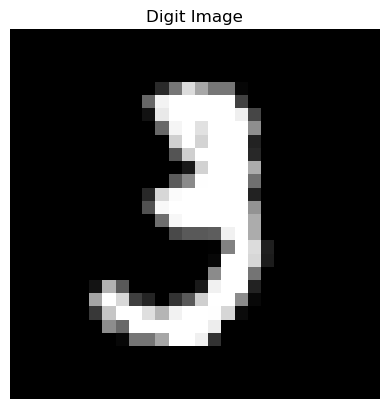

In [5]:
# visualize a digit

image_data = df.drop(columns="label").iloc[10].values  # Extract the pixel values as a numpy array
image_reshaped = image_data.reshape(28, 28)  # Reshape the 1D array (784,) to 2D (28, 28)

# Plot the reshaped image
plt.imshow(image_reshaped, cmap="gray")
plt.title('Digit Image')
plt.axis('off')  # Turn off axis for cleaner visualization
plt.show()


## Split Data

In [4]:
# Split Data into Features and Target
features = torch.tensor(df.drop(columns="label").to_numpy()).float()
target = torch.tensor(df.label.to_numpy()).float()

In [6]:
# Get the number of features and number of classes
n_features = features.shape[1]
n_classes = df.label.nunique()

In [7]:
# Create a random number generator and set the seed to 42 for reproducibility.
generator = torch.Generator().manual_seed(42)

In [8]:
# Combine the features and target tensors into a dataset object (TensorDataset).
dataset = TensorDataset(features, target)

# Split the dataset into training, validation, and test sets in the ratio of 70%, 20%, and 10%, respectively.
train_data, val_data, test_data = random_split(dataset, [0.7, 0.2, 0.1], generator=generator)

In [9]:
# Create a DataLoader for the training data.
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

# Create a DataLoader for the validation data.
val_loader = DataLoader(val_data, batch_size=16, shuffle=True)

# Create a DataLoader for the test data.
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)


## Build Model

In [19]:
# Define a neural network model
model = nn.Sequential(
    nn.Linear(n_features, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(32, n_classes),
    nn.Softmax(dim=-1)
)

In [11]:
# Define the loss function for the model.
criterion = nn.CrossEntropyLoss()

In [12]:
# Initialize the Adam optimizer for the model's parameters.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
# Initialize the accuracy metric for evaluating model performance
accuracy = Accuracy(task="multiclass", num_classes=n_classes)

## Train Model

In [14]:
# Lists to store the training and validation losses, and validation accuracy for each epoch
train_losses = []
val_losses = []
val_acc = []

# Loop through each epoch for training the model (100 epochs)
for epoch in range(100):
    train_loss = 0.0  # Initialize the training loss for the current epoch
    
    # Iterate through the training data in batches
    for batch in train_loader:
        features, target = batch  # Unpack the batch into features and target labels
        optimizer.zero_grad()  # Clear the gradients from the previous iteration
        output = model(features)  # Forward pass: compute the model's predictions
        loss = criterion(output, target.long())  # Compute the loss using the output and target
        loss.backward()  # Backward pass: compute gradients
        optimizer.step()  # Update the model parameters using the optimizer

        train_loss += loss.item()  # Accumulate the training loss for this batch

    avg_batch_loss = train_loss / len(train_loader)  # Calculate average loss for the epoch
    train_losses.append(avg_batch_loss)  # Store the average training loss

    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0  # Initialize the validation loss for the current epoch
    
    with torch.no_grad():  # Disable gradient calculation for validation to save memory
        # Iterate through the validation data in batches
        for val in val_loader:
            X_val, y_val = val  # Unpack the validation batch into features and target labels
            val_pred = model(X_val)  # Forward pass: compute predictions on the validation set
            loss_v = criterion(val_pred, y_val.long())  # Compute the validation loss
            val_loss += loss_v.item()  # Accumulate the validation loss
            
            accuracy(val_pred, y_val.view(-1))  # Compute accuracy for the current validation batch
            
    val_accuracy = accuracy.compute()  # Calculate overall validation accuracy
    avg_val_loss = val_loss / len(val_loader)  # Calculate average validation loss
    val_losses.append(avg_val_loss)  # Store the average validation loss
    val_acc.append(val_accuracy)  # Store the validation accuracy
    
    # Print the training and validation metrics for the current epoch
    print(f"Epoch {epoch+1} is done with train_loss of {avg_batch_loss:.4f} and val_loss: {avg_val_loss:.4f}; val accuracy:{val_accuracy:.2f}")
    
    model.train()  # Set the model back to training mode for the next epoch


Epoch 1 is done with train_loss of 1.8947 and val_loss: 1.7401; val accuracy:0.72
Epoch 2 is done with train_loss of 1.7442 and val_loss: 1.6745; val accuracy:0.75
Epoch 3 is done with train_loss of 1.7147 and val_loss: 1.6734; val accuracy:0.76
Epoch 4 is done with train_loss of 1.6969 and val_loss: 1.6218; val accuracy:0.78
Epoch 5 is done with train_loss of 1.6648 and val_loss: 1.6074; val accuracy:0.80
Epoch 6 is done with train_loss of 1.6396 and val_loss: 1.5939; val accuracy:0.81
Epoch 7 is done with train_loss of 1.6347 and val_loss: 1.6022; val accuracy:0.82
Epoch 8 is done with train_loss of 1.6271 and val_loss: 1.5890; val accuracy:0.82
Epoch 9 is done with train_loss of 1.6263 and val_loss: 1.5872; val accuracy:0.83
Epoch 10 is done with train_loss of 1.6144 and val_loss: 1.5676; val accuracy:0.84
Epoch 11 is done with train_loss of 1.6115 and val_loss: 1.5709; val accuracy:0.84
Epoch 12 is done with train_loss of 1.6120 and val_loss: 1.5749; val accuracy:0.84
Epoch 13 is d

# Evaluate Model

In [20]:
# Initialize the test loss to zero
test_loss = 0.0

# Set the model to evaluation mode to disable dropout and batch normalization
model.eval()

# Disable gradient calculation for efficiency since we are only testing
with torch.no_grad():
    # Iterate over the test data in batches
    for data in test_loader:
        X_test, y_test = data
        
        # Forward pass: compute the model output
        output = model(X_test)
        
        # Compute the loss for the current batch using the criterion
        loss_t = criterion(output, y_test.long())
        
        # Accumulate the loss over all batches
        test_loss += loss_t
        
        # Compute the accuracy for the current batch
        accuracy(output, y_test.view(-1))

# Compute the overall test accuracy from the accumulated accuracy
test_acc = accuracy.compute()

# Calculate the average test loss by dividing the total loss by the number of batches
avg_test_loss = test_loss / len(test_loader)

# Print the average test loss and test accuracy as a percentage
print(f"Test Loss: {avg_test_loss:.2f}; Test Accuracy: {test_acc:.2%}")


Test Loss: 2.32; Test Accuracy: 89.36%


## Communicate result

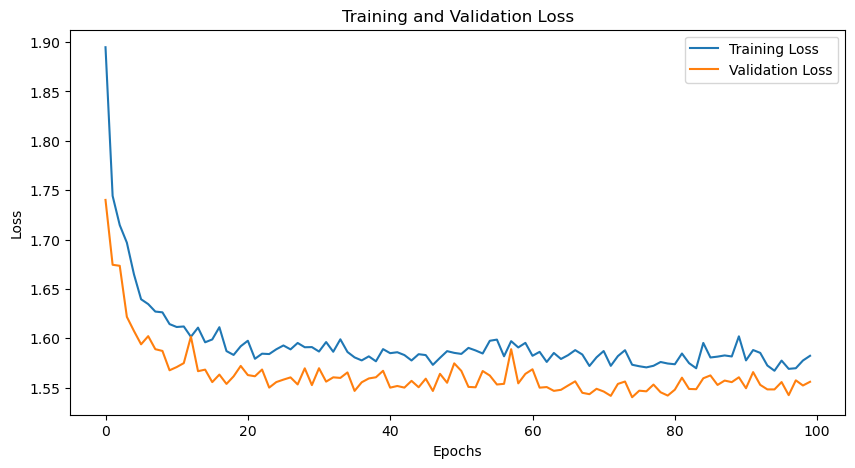

In [21]:
# Plot the training and validation losses over the epochs
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();
#plt.grid()
plt.savefig("Train and Val loss Final.png")

In [24]:
# Compute the mean of the validation accuracies across all epochs.
val_acc = np.mean(val_acc)

print(F"Val Accuracy: {val_acc:.2%}")

Val Accuracy: 87.48%


## Save model

In [27]:
# Save the model parameters to a file named 'model.pth'
torch.save(model.state_dict(), 'model.pth')  

In [ ]:
# # # Plot the validation accuracy over the epochs
# plt.figure(figsize=(8, 4))

# # plt.plot(val_acc, label='Validation Accuracy', color='green')
# plt.title('Validation Accuracy Over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy (%)')
# plt.legend()
# plt.grid(True)

# # Save the plot as an image file named "Val Accuracy.png"
# plt.savefig("Val Accuracy.png")
